--- Sample DataFrame Head ---
                  Open       Close
Date                              
2023-01-01  133.596161  110.456967
2023-01-02  106.963589  112.277085
2023-01-03  128.950530  112.088065
2023-01-04  140.253674  111.178996
2023-01-05  120.036240  110.956261


--- Processed Data for Column: 'Close' ---
Original Scaled Pandas Series shape (length): 150
NumPy array for pyts (X_ts_pyts) shape: (1, 150)
NumPy 1D array (X_ts_1d) shape: (150,)
Time steps: 150
------------------------------
--- Transformed Image Shapes ---
GASF image shape: (1, 150, 150)
GADF image shape: (1, 150, 150)
Recurrence Plot image shape: (1, 150, 150)
Markov Transition Field image shape: (1, 150, 150)
Spectrogram (dB) image shape: (19, 9)
Scalogram (magnitude) image shape: (75, 150)
------------------------------


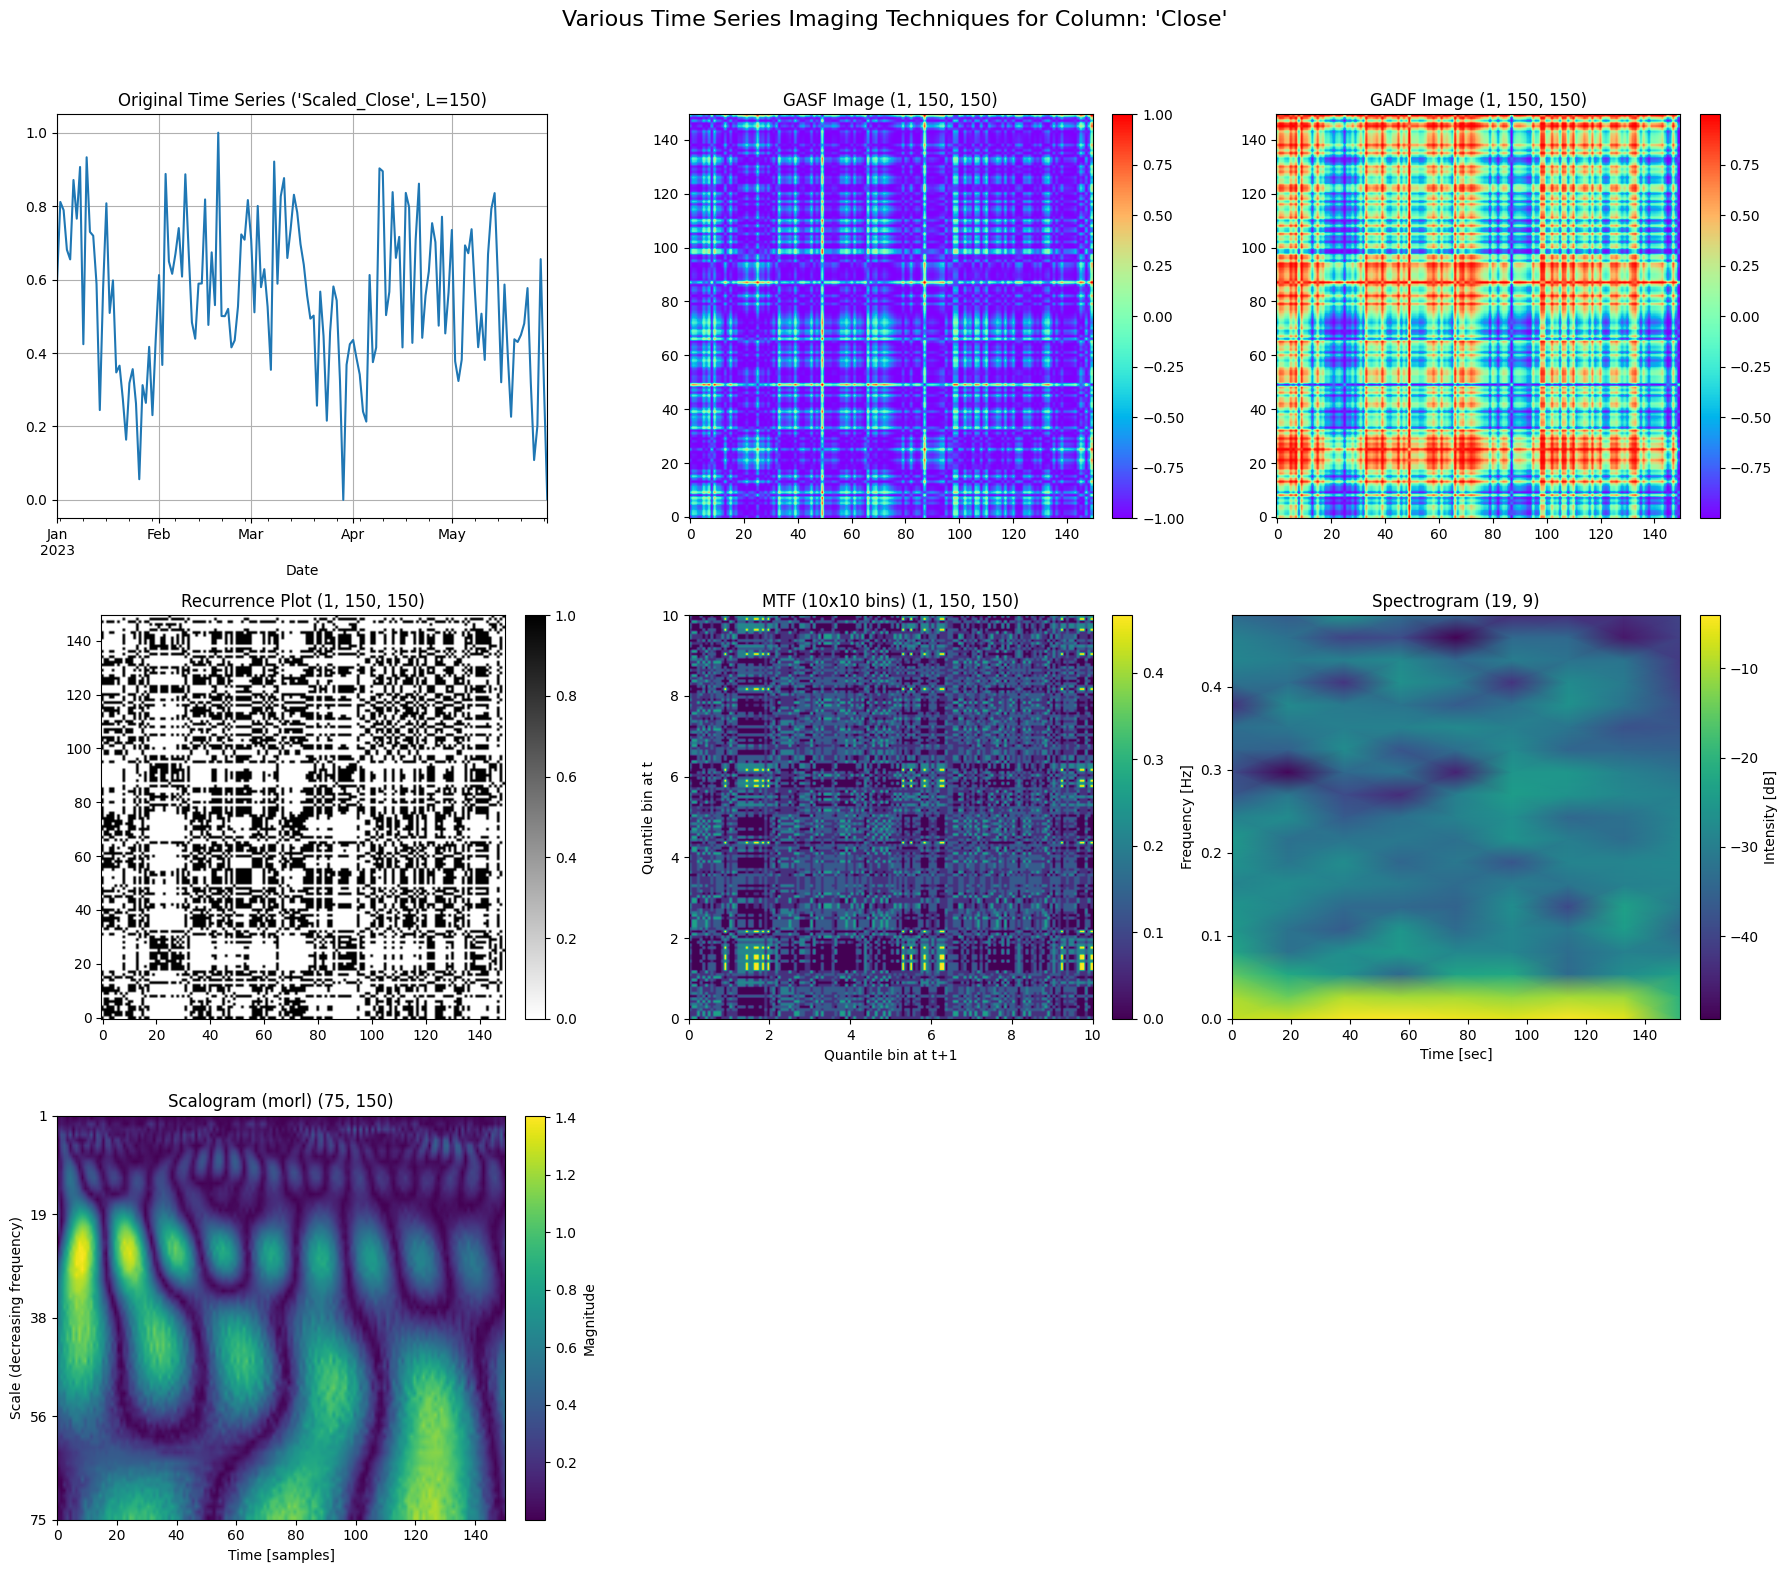

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField, RecurrencePlot, MarkovTransitionField
from scipy.signal import stft
import pywt
np.set_printoptions(precision=6, suppress=True)
class TimeSeriesDataGenerator:
    """
    외부 Pandas DataFrame과 컬럼 이름을 입력받아 해당 컬럼을 시계열 데이터로 처리하고,
    관련 속성들을 설정한 후 그 값들을 반환하는 클래스.
    """
    def __init__(self, feature_range=(0, 1)):
        """
        :param feature_range: 스케일링 시 사용할 값의 범위
        """
        self.feature_range = feature_range
        self.original_series_scaled = None # 스케일링된 Pandas Series
        self.X_ts_pyts = None             # pyts 라이브러리 입력용 NumPy 배열 (N, L)
        self.X_ts_1d = None               # scipy, pywt 입력용 NumPy 배열 (L,)
        self.time_steps = 0               # 처리된 시계열의 길이 (L)
        self.processed_column_name = None # 처리된 컬럼의 이름

    def process_dataframe_column(self, dataframe: pd.DataFrame, column_name: str):
        """
        입력 DataFrame에서 지정된 컬럼을 추출하고 스케일링한 후, 클래스 속성을 설정하고 값들을 반환합니다.
        
        :param dataframe: 입력 Pandas DataFrame
        :param column_name: 사용할 시계열 데이터가 있는 컬럼 이름
        :return: Tuple (self.original_series_scaled, self.X_ts_pyts, self.X_ts_1d, self.time_steps)
                 또는 오류 발생 시 (None, None, None, 0)
        :raises ValueError: 컬럼이 존재하지 않거나 비어있는 경우
        """
        if column_name not in dataframe.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

        # 지정된 컬럼을 Pandas Series로 추출
        original_series = dataframe[column_name].copy()
        
        if original_series.empty:
            raise ValueError(f"The selected column '{column_name}' is empty.")

        self.time_steps = len(original_series)
        self.processed_column_name = column_name

        scaler = MinMaxScaler(feature_range=self.feature_range)
        # MinMaxScaler는 NumPy 배열을 반환하므로, 다시 Series로 만듭니다.
        # Series의 인덱스를 유지합니다.
        scaled_values = scaler.fit_transform(original_series.values.reshape(-1, 1)).flatten()
        self.original_series_scaled = pd.Series(scaled_values, index=original_series.index, name=f"Scaled_{column_name}")

        # NumPy 배열 형태도 준비
        # pyts는 (n_samples, n_timesteps)를 기대하므로, 단일 시계열이라도 2D로 만듦
        self.X_ts_pyts = self.original_series_scaled.values.reshape(1, -1) 
        self.X_ts_1d = self.original_series_scaled.values # 1D 형태
        
        return self.original_series_scaled, self.X_ts_pyts, self.X_ts_1d, self.time_steps

# --- (이하 다른 클래스들은 이전과 동일하게 유지) ---
class GramianAngularFieldConverter:
    """Gramian Angular Fields (GASF, GADF) 이미지를 생성하는 클래스."""
    def __init__(self, image_size):
        self.image_size = image_size

    def transform(self, time_series_pyts_input):
        gasf_transformer = GramianAngularField(image_size=self.image_size, method='summation')
        X_gasf = gasf_transformer.fit_transform(time_series_pyts_input)
        gadf_transformer = GramianAngularField(image_size=self.image_size, method='difference')
        X_gadf = gadf_transformer.fit_transform(time_series_pyts_input)
        return X_gasf, X_gadf

class RecurrencePlotConverter:
    """Recurrence Plot (RP) 이미지를 생성하는 클래스."""
    def __init__(self, threshold=0.15):
        self.threshold = threshold

    def transform(self, time_series_pyts_input):
        rp_transformer = RecurrencePlot(threshold=self.threshold)
        X_rp = rp_transformer.fit_transform(time_series_pyts_input)
        return X_rp

class MarkovTransitionFieldConverter:
    """Markov Transition Fields (MTF) 이미지를 생성하는 클래스."""
    def __init__(self, n_bins=10, strategy='quantile'):
        self.n_bins = n_bins
        self.strategy = strategy

    def transform(self, time_series_pyts_input):
        mtf_transformer = MarkovTransitionField(n_bins=self.n_bins, strategy=self.strategy)
        X_mtf = mtf_transformer.fit_transform(time_series_pyts_input)
        return X_mtf

class SpectrogramConverter:
    """STFT를 사용하여 스펙트로그램을 생성하는 클래스."""
    def __init__(self, fs=1.0, nperseg_ratio=0.25, noverlap_ratio=0.5):
        self.fs = fs
        self.nperseg_ratio = nperseg_ratio
        self.noverlap_ratio = noverlap_ratio

    def transform(self, time_series_1d_input):
        if len(time_series_1d_input) == 0:
            return np.array([]), np.array([]), np.array([])
            
        nperseg = int(len(time_series_1d_input) * self.nperseg_ratio)
        if nperseg == 0: nperseg = max(1, int(len(time_series_1d_input) * 0.1)) 
        if nperseg > len(time_series_1d_input): nperseg = len(time_series_1d_input)
        
        noverlap = int(nperseg * self.noverlap_ratio)
        if noverlap >= nperseg and nperseg > 0 : noverlap = nperseg -1

        nfft = nperseg

        if len(time_series_1d_input) < nperseg:
             nperseg = len(time_series_1d_input)
             noverlap = 0 

        frequencies, times, Zxx = stft(time_series_1d_input, fs=self.fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        spectrogram_magnitude = np.abs(Zxx)
        spectrogram_db = 20 * np.log10(spectrogram_magnitude + 1e-9)
        return frequencies, times, spectrogram_db

class ScalogramConverter:
    """CWT를 사용하여 웨이블릿 스케일로그램을 생성하는 클래스."""
    def __init__(self, wavelet_name='morl', max_scale_ratio=0.5, fs=1.0):
        self.wavelet_name = wavelet_name
        self.max_scale_ratio = max_scale_ratio
        self.fs = fs

    def transform(self, time_series_1d_input):
        time_steps_len = len(time_series_1d_input)
        if time_steps_len == 0:
            return np.array([]), np.array([]), np.array([]), self.wavelet_name

        max_scale = int(time_steps_len * self.max_scale_ratio)
        if max_scale < 1: max_scale = 1
        scales = np.arange(1, max_scale + 1)
        
        coefficients, frequencies = pywt.cwt(time_series_1d_input, scales, self.wavelet_name, sampling_period=1.0/self.fs)
        scalogram_magnitude = np.abs(coefficients)
        return scalogram_magnitude, scales, frequencies, self.wavelet_name

class TimeSeriesVisualizer:
    """시계열 데이터와 변환된 이미지들을 시각화하는 클래스."""
    def plot_all(self, original_series, 
                   time_steps,
                   column_name_for_title: str, # 컬럼 이름 추가
                   gasf_img, gadf_img, rp_img, mtf_img, mtf_n_bins,
                   spec_data, scal_data):
        fig, axs = plt.subplots(3, 3, figsize=(18, 16))
        fig.suptitle(f"Various Time Series Imaging Techniques for Column: '{column_name_for_title}'", fontsize=16)

        # 1. Original Time Series
        if original_series is not None and not original_series.empty:
            original_series.plot(ax=axs[0, 0], grid=True)
            axs[0, 0].set_title(f"Original Time Series ('{original_series.name}', L={time_steps})")
        else:
            axs[0,0].text(0.5, 0.5, "No data", ha='center', va='center')
            axs[0,0].set_title("Original Time Series")

        # 2. GASF
        if gasf_img is not None and gasf_img.size > 0:
            img_gasf = axs[0, 1].imshow(gasf_img[0], cmap='rainbow', origin='lower')
            axs[0, 1].set_title(f"GASF Image {gasf_img.shape}")
            fig.colorbar(img_gasf, ax=axs[0, 1], fraction=0.046, pad=0.04)
        else:
            axs[0,1].text(0.5, 0.5, "No GASF data", ha='center', va='center')
            axs[0,1].set_title("GASF Image")
        # ... (이하 다른 이미지 플롯들도 유사하게 None 및 size 체크 추가)
        # 3. GADF
        if gadf_img is not None and gadf_img.size > 0:
            img_gadf = axs[0, 2].imshow(gadf_img[0], cmap='rainbow', origin='lower')
            axs[0, 2].set_title(f"GADF Image {gadf_img.shape}")
            fig.colorbar(img_gadf, ax=axs[0, 2], fraction=0.046, pad=0.04)
        else:
            axs[0,2].text(0.5, 0.5, "No GADF data", ha='center', va='center')
            axs[0,2].set_title("GADF Image")

        # 4. Recurrence Plot
        if rp_img is not None and rp_img.size > 0:
            img_rp = axs[1, 0].imshow(rp_img[0], cmap='binary', origin='lower')
            axs[1, 0].set_title(f"Recurrence Plot {rp_img.shape}")
            fig.colorbar(img_rp, ax=axs[1, 0], fraction=0.046, pad=0.04)
        else:
            axs[1,0].text(0.5, 0.5, "No RP data", ha='center', va='center')
            axs[1,0].set_title("Recurrence Plot")

        # 5. Markov Transition Field
        if mtf_img is not None and mtf_img.size > 0:
            img_mtf = axs[1, 1].imshow(mtf_img[0], cmap='viridis', origin='lower', extent=(0, mtf_n_bins, 0, mtf_n_bins))
            axs[1, 1].set_title(f"MTF ({mtf_n_bins}x{mtf_n_bins} bins) {mtf_img.shape}")
            axs[1, 1].set_xlabel("Quantile bin at t+1")
            axs[1, 1].set_ylabel("Quantile bin at t")
            fig.colorbar(img_mtf, ax=axs[1, 1], fraction=0.046, pad=0.04)
        else:
            axs[1,1].text(0.5, 0.5, "No MTF data", ha='center', va='center')
            axs[1,1].set_title("Markov Transition Field")

        # 6. Spectrogram (STFT)
        spec_freq, spec_time, spec_db = spec_data
        if spec_db is not None and spec_db.size > 0:
            img_spec = axs[1, 2].pcolormesh(spec_time, spec_freq, spec_db, shading='gouraud', cmap='viridis')
            axs[1, 2].set_ylabel('Frequency [Hz]')
            axs[1, 2].set_xlabel('Time [sec]')
            axs[1, 2].set_title(f'Spectrogram {spec_db.shape}')
            fig.colorbar(img_spec, ax=axs[1, 2], fraction=0.046, pad=0.04, label='Intensity [dB]')
        else:
            axs[1,2].text(0.5, 0.5, "No Spectrogram data", ha='center', va='center')
            axs[1,2].set_title("Spectrogram (STFT)")

        # 7. Wavelet Scalogram (CWT)
        scal_mag, scal_scales, _, scal_wavelet_name = scal_data 
        if scal_mag is not None and scal_mag.size > 0 and scal_scales is not None and scal_scales.size > 0:
            max_scale_val = scal_scales[-1]
            img_scal = axs[2, 0].imshow(scal_mag, extent=[0, time_steps, max_scale_val, 1], cmap='viridis', aspect='auto', interpolation='bilinear')
            if len(scal_scales) > 0:
                 axs[2,0].set_yticks(np.linspace(1, max_scale_val, min(5, len(scal_scales)), dtype=int if max_scale_val >=1 else float))
            axs[2, 0].set_ylabel('Scale (decreasing frequency)')
            axs[2, 0].set_xlabel('Time [samples]')
            axs[2, 0].set_title(f'Scalogram ({scal_wavelet_name}) {scal_mag.shape}')
            fig.colorbar(img_scal, ax=axs[2, 0], fraction=0.046, pad=0.04, label='Magnitude')
        else:
            axs[2,0].text(0.5, 0.5, "No Scalogram data", ha='center', va='center')
            axs[2,0].set_title("Wavelet Scalogram (CWT)")

        axs[2, 1].axis('off')
        axs[2, 2].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if __name__ == '__main__':
    # --- 샘플 DataFrame 생성 ---
    num_points = 150
    date_rng = pd.date_range(start='2023-01-01', periods=num_points, freq='D')
    sample_df = pd.DataFrame(date_rng, columns=['Date'])
    sample_df['Open'] = np.random.rand(num_points) * 50 + 100
    t_main = np.linspace(0, 20, num_points)
    sample_df['Close'] = np.sin(t_main * 1.5) + np.cos(t_main * 0.8) + np.random.normal(0, 1.5, num_points) + 110
    sample_df.set_index('Date', inplace=True)

    print("--- Sample DataFrame Head ---")
    print(sample_df.head())
    print("\n")

    # --- 데이터 처리기 인스턴스화 ---
    data_processor = TimeSeriesDataGenerator(feature_range=(0, 1))
    target_column_to_process = 'Close' # 처리할 단일 컬럼 지정

    try:
        # DataFrame과 컬럼 이름을 전달하여 처리
        processed_series, np_ts_pyts, np_ts_1d, current_time_steps = data_processor.process_dataframe_column(
            sample_df, target_column_to_process
        )

        print(f"--- Processed Data for Column: '{data_processor.processed_column_name}' ---")
        print(f"Original Scaled Pandas Series shape (length): {processed_series.shape[0]}")
        print(f"NumPy array for pyts (X_ts_pyts) shape: {np_ts_pyts.shape}")
        print(f"NumPy 1D array (X_ts_1d) shape: {np_ts_1d.shape}")
        print(f"Time steps: {current_time_steps}")
        print("-" * 30)

        # --- 이미지 변환 ---
        # 클래스 속성에 저장된 값 또는 반환된 값을 사용할 수 있음
        # 여기서는 반환된 값을 사용
        print("--- Transformed Image Shapes ---")
        gasf_image, gadf_image, rp_image, mtf_image = None, None, None, None
        spectrogram_data = (np.array([]), np.array([]), np.array([]))
        scalogram_data = (np.array([]), np.array([]), np.array([]), '')

        if current_time_steps >= 20: # 최소 길이 체크
            gaf_converter = GramianAngularFieldConverter(image_size=current_time_steps)
            gasf_image, gadf_image = gaf_converter.transform(np_ts_pyts)
            print(f"GASF image shape: {gasf_image.shape}")
            print(f"GADF image shape: {gadf_image.shape}")

            rp_converter = RecurrencePlotConverter(threshold=0.15)
            rp_image = rp_converter.transform(np_ts_pyts)
            print(f"Recurrence Plot image shape: {rp_image.shape}")

            mtf_converter = MarkovTransitionFieldConverter(n_bins=10)
            mtf_image = mtf_converter.transform(np_ts_pyts)
            print(f"Markov Transition Field image shape: {mtf_image.shape}")

            spectrogram_converter = SpectrogramConverter(fs=1.0, nperseg_ratio=0.25)
            spec_frequencies, spec_times, spec_db_image = spectrogram_converter.transform(np_ts_1d)
            print(f"Spectrogram (dB) image shape: {spec_db_image.shape}")
            spectrogram_data = (spec_frequencies, spec_times, spec_db_image)

            scalogram_converter = ScalogramConverter(wavelet_name='morl', max_scale_ratio=0.5, fs=1.0)
            scalogram_mag_image, scal_scales_arr, scal_freq_arr, scal_w_name = scalogram_converter.transform(np_ts_1d)
            print(f"Scalogram (magnitude) image shape: {scalogram_mag_image.shape}")
            scalogram_data = (scalogram_mag_image, scal_scales_arr, scal_freq_arr, scal_w_name)
        else:
            print(f"Warning: Time series length ({current_time_steps}) is too short for some transformations.")
        print("-" * 30)
        
        # --- 시각화 ---
        visualizer = TimeSeriesVisualizer()
        visualizer.plot_all(
            original_series=processed_series, # 또는 data_processor.original_series_scaled
            time_steps=current_time_steps,    # 또는 data_processor.time_steps
            column_name_for_title=data_processor.processed_column_name, # 클래스 속성 사용
            gasf_img=gasf_image,
            gadf_img=gadf_image,
            rp_img=rp_image,
            mtf_img=mtf_image,
            mtf_n_bins=mtf_converter.n_bins if 'mtf_converter' in locals() and current_time_steps >=20 else 10,
            spec_data=spectrogram_data,
            scal_data=scalogram_data
        )

    except ValueError as e:
        print(f"Error during data processing: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

In [3]:
import numpy as np
from typing import List

def combine_multiple_images_along_first_axis(image_list: List[np.ndarray]) -> np.ndarray:
    """
    Shape (1, H, W)를 갖는 여러 이미지 배열들을 리스트로 받아, 
    첫 번째 축을 따라 결합하여 Shape (N, H, W)의 단일 이미지 배열로 만듭니다.
    N은 리스트에 있는 이미지의 개수입니다.

    Args:
        image_list (List[np.ndarray]): Shape (1, H, W)를 갖는 이미지 배열들의 리스트.
                                      리스트 내 모든 이미지의 H와 W는 동일해야 합니다.

    Returns:
        np.ndarray: 결합된 이미지 배열. Shape는 (N, H, W)입니다.

    Raises:
        ValueError: 입력 이미지 리스트가 비어 있거나, 이미지들의 shape 또는
                    H, W 크기가 적절하지 않은 경우 발생합니다.
    """
    if not image_list:
        raise ValueError("입력 이미지 리스트가 비어 있습니다.")

    # 첫 번째 이미지를 기준으로 shape 검증 및 H, W 크기 저장
    first_image_shape = image_list[0].shape
    if not (len(first_image_shape) == 3 and first_image_shape[0] == 1):
        raise ValueError(f"리스트의 첫 번째 이미지 shape는 (1, H, W)여야 합니다. 현재 shape: {first_image_shape}")
    
    expected_h = first_image_shape[1]
    expected_w = first_image_shape[2]

    # 리스트 내 다른 이미지들의 shape 및 H, W 크기 검증
    for i, image in enumerate(image_list):
        if not (image.ndim == 3 and image.shape[0] == 1):
            raise ValueError(f"리스트의 {i+1}번째 이미지 shape는 (1, H, W)여야 합니다. 현재 shape: {image.shape}")
        if image.shape[1] != expected_h or image.shape[2] != expected_w:
            raise ValueError(f"리스트의 모든 이미지의 높이(H)와 너비(W)가 일치해야 합니다. "
                             f"첫 번째 이미지 HxW: {expected_h}x{expected_w}, "
                             f"{i+1}번째 이미지 HxW: {image.shape[1]}x{image.shape[2]}")

    # 첫 번째 축(axis=0)을 따라 모든 이미지를 연결합니다.
    # image_list에 있는 배열들이 concatenate의 입력으로 바로 사용됩니다.
    
    squeezed_images = [img.squeeze(axis=0) for img in image_list] # 각 이미지를 (H,W)로 만듦
    combined_image = np.stack(squeezed_images, axis=0)
    #combined_image = np.concatenate(image_list, axis=0)
    
    return combined_image

if __name__ == '__main__':
    # 테스트용 샘플 이미지 생성
    num_images_to_combine = 5
    H, W = 128, 128
    
    list_of_images = []
    for i in range(num_images_to_combine):
        # 각 이미지는 (1, H, W) shape를 가집니다.
        # 값은 예시를 위해 간단히 i 값으로 채웁니다.
        img = np.full((1, H, W), fill_value=i, dtype=np.uint8)
        list_of_images.append(img)
        print(f"Shape of img_{i+1}: {img.shape}")

    print(f"\n총 {len(list_of_images)}개의 이미지를 결합합니다.")

    # 함수를 사용하여 이미지 결합
    try:
        combined_result = combine_multiple_images_along_first_axis(list_of_images)
        print(f"\nShape of combined_result: {combined_result.shape}") # 예상: (num_images_to_combine, H, W)
        
        # 결합된 결과의 일부 값 확인 (선택 사항)
        # for i in range(num_images_to_combine):
        #     print(f"\nCombined result (채널 {i}, 첫 5x5 부분):")
        #     print(combined_result[i, :5, :5])

    except ValueError as e:
        print(f"Error: {e}")

    print("\n--- 빈 리스트로 시도 (오류 발생 예상) ---")
    empty_list = []
    try:
        combine_multiple_images_along_first_axis(empty_list)
    except ValueError as e:
        print(f"Error (empty_list): {e}")

    print("\n--- 다른 shape의 이미지가 포함된 경우 (오류 발생 예상) ---")
    invalid_list = [
        np.zeros((1, H, W), dtype=np.uint8),
        np.ones((H, W), dtype=np.uint8), # 잘못된 shape (2D)
        np.full((1, H, W), fill_value=2, dtype=np.uint8)
    ]
    try:
        combine_multiple_images_along_first_axis(invalid_list)
    except ValueError as e:
        print(f"Error (invalid_list with wrong shape): {e}")

    invalid_list_hw = [
        np.zeros((1, H, W), dtype=np.uint8),
        np.ones((1, H, W-10), dtype=np.uint8), # 잘못된 너비
        np.full((1, H, W), fill_value=2, dtype=np.uint8)
    ]
    try:
        combine_multiple_images_along_first_axis(invalid_list_hw)
    except ValueError as e:
        print(f"Error (invalid_list with different H/W): {e}")

    print("\n--- np.stack() 사용 예시 (참고) ---")
    # 만약 입력 이미지가 (H, W) 형태의 2D 이미지 리스트라면,
    list_of_2d_images = [np.full((H, W), i) for i in range(num_images_to_combine)]
    stacked_2d_result = np.stack(list_of_2d_images, axis=0)
    print(f"Shape of stacked_2d_result (from list of 2D images): {stacked_2d_result.shape}") # (N, H, W)

    # 만약 입력 이미지가 (1, H, W) 형태의 3D 이미지 리스트이고 squeeze 후 stack한다면,
    squeezed_images = [img.squeeze(axis=0) for img in list_of_images] # 각 이미지를 (H,W)로 만듦
    stacked_squeezed_result = np.stack(squeezed_images, axis=0)
    print(f"Shape of stacked_squeezed_result (from list of squeezed 3D images): {stacked_squeezed_result.shape}") # (N, H, W)

Shape of img_1: (1, 128, 128)
Shape of img_2: (1, 128, 128)
Shape of img_3: (1, 128, 128)
Shape of img_4: (1, 128, 128)
Shape of img_5: (1, 128, 128)

총 5개의 이미지를 결합합니다.

Shape of combined_result: (5, 128, 128)

--- 빈 리스트로 시도 (오류 발생 예상) ---
Error (empty_list): 입력 이미지 리스트가 비어 있습니다.

--- 다른 shape의 이미지가 포함된 경우 (오류 발생 예상) ---
Error (invalid_list with wrong shape): 리스트의 2번째 이미지 shape는 (1, H, W)여야 합니다. 현재 shape: (128, 128)
Error (invalid_list with different H/W): 리스트의 모든 이미지의 높이(H)와 너비(W)가 일치해야 합니다. 첫 번째 이미지 HxW: 128x128, 2번째 이미지 HxW: 128x118

--- np.stack() 사용 예시 (참고) ---
Shape of stacked_2d_result (from list of 2D images): (5, 128, 128)
Shape of stacked_squeezed_result (from list of squeezed 3D images): (5, 128, 128)


In [4]:
import numpy as np

def add_batch_channel_dim(image_2d: np.ndarray) -> np.ndarray:
    """
    Shape (H, W)를 갖는 2D 이미지 배열에 첫 번째 축을 추가하여
    Shape (1, H, W)의 3D 이미지 배열로 변환합니다.
    이는 단일 이미지를 배치 크기 1 또는 채널 수 1로 간주할 때 사용됩니다.

    Args:
        image_2d (np.ndarray): 2D 이미지 배열. Shape는 (H, W)여야 합니다.

    Returns:
        np.ndarray: 변환된 3D 이미지 배열. Shape는 (1, H, W)입니다.
    """
    if image_2d.ndim == 2:
        image_3d = np.expand_dims(image_2d, axis=0)
        return image_3d
    elif image_2d.ndim == 3: # 이미 3D 이미지 배열이면 
        return image_2d # 그대로 반환
    else:
        raise ValueError(f"입력 이미지의 차원이 잘못되었습니다. 현재 차원: {image_2d.ndim}")
    
# --- 다른 방법들 (참고용) ---
def add_batch_channel_dim_reshape(image_2d: np.ndarray) -> np.ndarray:
    """reshape()을 사용하여 (H, W) -> (1, H, W) 변환"""
    if image_2d.ndim != 2:
        raise ValueError(f"입력 이미지의 차원은 2여야 합니다 (H, W). 현재 차원: {image_2d.ndim}")
    return image_2d.reshape(1, image_2d.shape[0], image_2d.shape[1])

def add_batch_channel_dim_newaxis(image_2d: np.ndarray) -> np.ndarray:
    """np.newaxis를 사용하여 (H, W) -> (1, H, W) 변환"""
    if image_2d.ndim != 2:
        raise ValueError(f"입력 이미지의 차원은 2여야 합니다 (H, W). 현재 차원: {image_2d.ndim}")
    return image_2d[np.newaxis, :, :] # 또는 image_2d[None, :, :]


if __name__ == '__main__':
    # 테스트용 샘플 2D 이미지 생성
    H, W = 64, 128
    sample_2d_image = np.random.rand(H, W) 

    print(f"Original 2D image shape: {sample_2d_image.shape}") # (64, 128)

    # np.expand_dims() 사용 (권장)
    try:
        transformed_image_expand_dims = add_batch_channel_dim(sample_2d_image)
        print(f"Transformed image shape (using np.expand_dims): {transformed_image_expand_dims.shape}") # (1, 64, 128)
    except ValueError as e:
        print(f"Error (expand_dims): {e}")

    # reshape() 사용
    try:
        transformed_image_reshape = add_batch_channel_dim_reshape(sample_2d_image)
        print(f"Transformed image shape (using reshape): {transformed_image_reshape.shape}") # (1, 64, 128)
    except ValueError as e:
        print(f"Error (reshape): {e}")

    # np.newaxis 사용
    try:
        transformed_image_newaxis = add_batch_channel_dim_newaxis(sample_2d_image)
        print(f"Transformed image shape (using np.newaxis): {transformed_image_newaxis.shape}") # (1, 64, 128)
    except ValueError as e:
        print(f"Error (newaxis): {e}")
        
    print("\n--- 잘못된 차원의 입력으로 시도 (오류 발생 예상) ---")
    sample_1d_image = np.random.rand(H) # 1D 배열
    sample_3d_image = np.random.rand(1, H, W) # 이미 3D 배열

    try:
        add_batch_channel_dim(sample_1d_image)
    except ValueError as e:
        print(f"Error with 1D input: {e}")
        
    try:
        add_batch_channel_dim(sample_3d_image)
    except ValueError as e:
        print(f"Error with 3D input: {e}")

Original 2D image shape: (64, 128)
Transformed image shape (using np.expand_dims): (1, 64, 128)
Transformed image shape (using reshape): (1, 64, 128)
Transformed image shape (using np.newaxis): (1, 64, 128)

--- 잘못된 차원의 입력으로 시도 (오류 발생 예상) ---
Error with 1D input: 입력 이미지의 차원이 잘못되었습니다. 현재 차원: 1


In [5]:
def my_callback_function(message):
    print(f"콜백 실행됨: {message}")

def main_function(data, callback):
    print(f"주요 작업 처리 중: {data}")
    # ... 어떤 작업 수행 ...
    result = f"'{data}' 처리 완료"
    callback(result) # 저장된 콜백 함수 실행

# 콜백 함수를 main_function에 전달
main_function("중요 데이터", my_callback_function)

주요 작업 처리 중: 중요 데이터
콜백 실행됨: '중요 데이터' 처리 완료


In [6]:
callbacks = [] # 콜백 함수들을 저장할 리스트

def register_callback(func):
    """콜백 함수를 리스트에 등록합니다."""
    callbacks.append(func)

def execute_callbacks(data):
    """등록된 모든 콜백 함수를 실행합니다."""
    print(f"모든 콜백 실행 (데이터: {data})")
    for func in callbacks:
        func(data)

# 콜백 함수 정의
def callback_1(message):
    print(f"콜백 1: {message.upper()}")

def callback_2(message):
    print(f"콜백 2: {message.lower()}")

def callback_3(message):
    print(f"콜백 3: 길이 - {len(message)}")

# 콜백 함수 등록
register_callback(callback_1)
register_callback(callback_2)
register_callback(callback_3)

# 특정 시점에 모든 콜백 실행
execute_callbacks("Hello Python Callback")


모든 콜백 실행 (데이터: Hello Python Callback)
콜백 1: HELLO PYTHON CALLBACK
콜백 2: hello python callback
콜백 3: 길이 - 21


In [7]:
class EventManager:
    def __init__(self):
        self._callbacks = {} # 이벤트 이름별로 콜백 리스트를 저장할 딕셔너리

    def register(self, event_name, callback):
        """특정 이벤트에 콜백 함수를 등록합니다."""
        if event_name not in self._callbacks:
            self._callbacks[event_name] = []
        self._callbacks[event_name].append(callback)
        print(f"'{event_name}' 이벤트에 '{callback.__name__}' 콜백 등록됨")

    def unregister(self, event_name, callback):
        """특정 이벤트에서 콜백 함수를 제거합니다."""
        if event_name in self._callbacks and callback in self._callbacks[event_name]:
            self._callbacks[event_name].remove(callback)
            print(f"'{event_name}' 이벤트에서 '{callback.__name__}' 콜백 제거됨")
        else:
            print(f"'{event_name}' 이벤트에 '{callback.__name__}' 콜백이 등록되어 있지 않음")


    def trigger(self, event_name, *args, **kwargs):
        """특정 이벤트에 등록된 모든 콜백 함수를 실행합니다."""
        if event_name in self._callbacks:
            print(f"\n'{event_name}' 이벤트 발생! 콜백 실행:")
            for callback in self._callbacks[event_name]:
                callback(*args, **kwargs) # 인자와 함께 콜백 호출
        else:
            print(f"'{event_name}' 이벤트에 등록된 콜백이 없습니다.")
    

# 콜백 함수 정의
def on_data_received(data, source): # 이 함수는 data와 source를 모두 사용
    print(f"  데이터 수신: {data} (출처: {source})")

# 방법 2 적용: log_event가 source와 recipient를 선택적으로 받을 수 있도록 수정
def log_event(event_details, source=None, recipient=None, **other_kwargs):
    log_message = f"  이벤트 로깅: {event_details}"
    if source:
        log_message += f" (관련 출처: {source})" # 출처 정보가 있으면 로그에 포함
    if recipient:
        log_message += f" (관련 수신자: {recipient})" # 수신자 정보가 있으면 로그에 포함
    # other_kwargs는 현재 사용하지 않지만, 필요한 경우 로깅할 수 있음
    if other_kwargs:
        log_message += f" (기타 정보: {other_kwargs})"
    print(log_message)

def send_notification(message, recipient): # 이 함수는 message와 recipient를 사용
    print(f"  알림 발송: '{message}' -> {recipient}")

# EventManager 인스턴스 생성
manager = EventManager()

# 'data_received' 이벤트에 콜백 등록
manager.register("data_received", on_data_received)
#manager.register("data_received", log_event) # 같은 이벤트에 여러 콜백 등록 가능

# 'system_alert' 이벤트에 콜백 등록
manager.register("system_alert", send_notification)
#manager.register("system_alert", log_event)

# 이벤트 발생 시뮬레이션
manager.trigger("data_received", "새로운 메시지", source="Server A")
manager.trigger("system_alert", "서버 점검 시작", recipient="Admin Team")
manager.trigger("unknown_event") # 등록되지 않은 이벤트

# 콜백 제거
#manager.unregister("data_received", log_event)
manager.trigger("data_received", "업데이트된 메시지", source="Server B") # log_event는 실행 안 됨

'data_received' 이벤트에 'on_data_received' 콜백 등록됨
'system_alert' 이벤트에 'send_notification' 콜백 등록됨

'data_received' 이벤트 발생! 콜백 실행:
  데이터 수신: 새로운 메시지 (출처: Server A)

'system_alert' 이벤트 발생! 콜백 실행:
  알림 발송: '서버 점검 시작' -> Admin Team
'unknown_event' 이벤트에 등록된 콜백이 없습니다.

'data_received' 이벤트 발생! 콜백 실행:
  데이터 수신: 업데이트된 메시지 (출처: Server B)


In [8]:
import abc
import pandas as pd
from stock.stock_wallet import TrainStockWallet 
import numpy as np
import os
from common.fileManager import Config
from PPO.reward import BuySellReward, ExpReward
import random

class Adaptor:
    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def get_info(self):
        pass

    @abc.abstractmethod
    def get_info_len(self):
        pass
    
class DailyStockAdaptor(Adaptor):
    def __init__(self, data_filter, path):
        super().__init__()
        self.data_filter = data_filter
        self.path = path 

        filename = os.path.basename(path) # 주식 파일 추출
        self.stock_code = filename.split('.')[0] # 주식 코드 추출

        self.index = 0
        self.extra_index = 0

        self.silce_datas = None

    def load_datas(self, stock_code, count, extra_count = 0): # 데이터 읽어오기
        """
            저장된 주식데이터를 count만큼 가지고 옵니다.
        """
        self.index = extra_count
        self.extra_index = extra_count
        count += 1

        self.stock_datas = pd.read_csv(self.path + "/" + stock_code + ".csv", header=0, index_col=0)
        
        maxindex = len(self.stock_datas) - count - extra_count# 최대 인덱스 설정
        silce_index = random.randint(10, maxindex) # 인덱스 추출
        self.silce_datas = self.stock_datas.iloc[silce_index : silce_index + count + extra_count] # 슬라이싱
        
        self.silce_datas.index = np.arange(len(self.silce_datas.index)) # 인덱스 재정렬
        
        self.filtering_datas = self.silce_datas[list(self.data_filter)]# 데이터 필터링

        return self.filtering_datas



    # 주식 데이터 하나씩 가져오기
    def get_info(self):
        """
            load_datas()로 불러온 주식데이터를 하나씩 반환합니다.
        """
        self.price = float(self.filtering_datas["stck_clpr"].iloc[self.index])# 현재 가격 추출
        next_price = float(self.filtering_datas["stck_clpr"].iloc[self.index + 1])# 다음 날 가격 추출
        current_date = self.silce_datas["stck_bsop_date"][self.index] # 현재 날짜 가져오기

        data = self.filtering_datas.iloc[self.index].values
        
        done = len(self.filtering_datas) - 2 == self.index # 환경 종료 여부

        extra_datas = self.filtering_datas.iloc[self.index - self.extra_index : self.index].values # 추가 데이터 슬라이싱
        
        self.index += 1 # 다음 인덱스로 
        
        return data, extra_datas, done, {
                            "current_date": current_date,
                            "stock_code": self.stock_code,
                            "price": self.price,
                            "next_price": next_price
                            }

    

if __name__ == '__main__':
    stock_codes = [ "005930","000660", "083650", "010120", "035720", "012450", "098460", "064350", "056080", "068270", "039030" ] # "005930","000660", "083650", "010120", "035720", "012450", "098460", "064350", "056080", "068270", "039030"
    data_filter = ["stck_clpr","stck_hgpr","stck_lwpr","acml_vol","prdy_vrss",'5','20','60',"rsi","bb_upper","bb_lower"]
    stock_config = Config.load_config("config/StockConfig.yaml")
    a = DailyStockAdaptor(data_filter,str(stock_config.stock_code_path.value))
    np.set_printoptions(precision=6, suppress=True)
    a.load_datas(" 005930",30,0)
    for i in range(30):
        print(i)
        datas, extra_datas, done, info = a.get_info()
        print(datas)
        print(extra_datas)
        

0
[   49000.          49350.          48550.       23349760.
        0.          48930.          47465.          53875.833333
       55.940594    51314.168741    43615.831259]
[]
1
[   51400.          52000.          50300.       32041675.
     2400.          49390.          47887.5         53709.166667
       62.916667    51509.91287     44265.08713 ]
[]
2
[   50100.          51400.          50000.       21866354.
    -1300.          49560.          48122.5         53505.833333
       58.754864    51678.125824    44566.874176]
[]
3
[   49250.          49700.          48700.       27407543.
     -850.          49750.          48460.          53313.333333
       55.514706    50933.580401    45986.419599]
[]
4
[   49850.          50000.          48350.       18613864.
      600.          49920.          48605.          53164.166667
       66.530612    51047.314476    46162.685524]
[]
5
[   49850.          50300.          49500.       18754442.
        0.          50090.          48665.  

In [9]:
from common.fileManager import Config
import pandas as pd
import random
import os

data_filter = ["stck_clpr","stck_hgpr","stck_lwpr","acml_vol","prdy_vrss",'5','20','60',"rsi","bb_upper","bb_lower"]
stock_config = Config.load_config("config/StockConfig.yaml")
path = str(stock_config.stock_code_path.value) + "/" + " 005930" + ".csv"

filename = os.path.basename(path)
print(filename.split('.')[0])
datas = pd.read_csv(path, header=0, index_col=0)
#print(datas)
count = 360

maxindex = len(datas) - count
print(maxindex)
index = random.randint(10,maxindex)
print(index)
index = 10
silce_datas = datas.iloc[index : index + count]


silce_datas.index = np.arange(len(silce_datas.index)) # 인덱스 재정렬

filtering_datas = silce_datas[list(data_filter)]# 데이터 필터링

float(filtering_datas["stck_clpr"].iloc[index])# 가격 추출
print(filtering_datas)
np_filtering_datas = filtering_datas.iloc[1].values
np.insert(np_filtering_datas, 0, 1.0)

 005930
2140
2023
     stck_clpr  stck_hgpr  stck_lwpr  acml_vol  prdy_vrss          5  \
0      1349000    1357000    1319000    271062      30000  1313600.0   
1      1317000    1346000    1317000    319556     -32000  1317400.0   
2      1305000    1319000    1294000    409817     -12000  1318400.0   
3      1286000    1304000    1274000    287945     -19000  1315200.0   
4      1273000    1280000    1260000    286759     -13000  1306000.0   
..         ...        ...        ...       ...        ...        ...   
355    1269000    1280000    1269000    159211      -1000  1263800.0   
356    1286000    1286000    1269000    162251      17000  1271400.0   
357    1271000    1289000    1268000    208692     -15000  1272800.0   
358    1295000    1298000    1274000    237255      24000  1278200.0   
359    1296000    1303000    1295000    253073       1000  1283400.0   

            20            60        rsi      bb_upper      bb_lower  
0    1251000.0  1.191717e+06  80.751174  1.3478

array([      1.      , 1317000.      , 1346000.      , 1317000.      ,
        319556.      ,  -32000.      , 1317400.      , 1255350.      ,
       1193666.666667,      72.57384 , 1355765.686026, 1154934.313974])

In [ ]:
import os
import abc
import gym
import numpy as np
import random
import datetime
from sklearn.preprocessing import StandardScaler
from common.fileManager import Config, File
from PPO.reward import BuySellReward, ExpReward

from typing import (
    TYPE_CHECKING,
    Any,
    Tuple
)

from gym import Env
from gym import spaces
from stock.stock_adaptor import DailyStockAdaptor
from stock.stock_wallet import TrainStockWallet

class Environment:
    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def reset(self) -> Tuple[Any, dict]:
        pass
    
    @abc.abstractmethod
    def getObservation(self) -> spaces.Space:
        pass
    
    @abc.abstractmethod
    def getActon(self) -> spaces.Space:
        pass
    
    @abc.abstractmethod
    def getRewardRange(self) -> tuple[float, float]:
        pass
    
    @abc.abstractmethod
    def step(self, action) -> Tuple[Any, float, bool, bool, dict]:
        pass
    
    @abc.abstractmethod
    def render(self):
        pass

    @abc.abstractmethod
    def seed(self,random_seed):
        pass

    @abc.abstractmethod
    def close(self):
        pass
    
class GymEnvironment(Environment): # OpenAI gym 환경
    def __init__(self, env_name='CartPole-v1', render_mode = ""):
        super().__init__()
        
        if render_mode == "":
            self.env = gym.make(env_name)
        else:
            self.env = gym.make(env_name, render_mode=render_mode)
    
    def reset(self): # observation, info
        return self.env.reset()
        
    def getObservation(self): 
        return self.env.observation_space
    
    def getActon(self):
        return self.env.action_space
    
    def getRewardRange(self):
        return self.env.reward_range
    
    def step(self, action) : # (observation, reward, terminated, truncated, info) 
        return self.env.step(action)
    
    def render(self):
        self.env.render()

    def seed(self,random_seed):
        self.env.seed(random_seed)

    def close(self):
        self.env.close()

class StockEnvironment(Environment): # 주식 환경
    def __init__(self, stock_config=None):
        super().__init__()
        if stock_config == None:
            raise ValueError("stock_config is None")
        
        self.stock_config = stock_config

        self.min_dt = self.stock_config.min_dt.value
        self.max_dt = self.stock_config.max_dt.value
        self.stock_code_path = self.stock_config.stock_code_path.value
        self.defult_count = int(self.stock_config.count.value)

        self.stock = DailyStockAdaptor(self.stock_config.stock_columns, self.stock_code_path)

        self.wallet = TrainStockWallet()
        self.reward_cls = ExpReward()

        self.observation_space = spaces.Box(low = -np.inf, high= np.inf, shape= (len(self.reset()[0]),), dtype=np.float32)
        self.action_space = spaces.Box(low= -1, high= 1, shape=(1,), dtype=np.float32)

    def reset(self) -> Tuple[Any, dict]: # ndarray, {None}
        self.stock_code = self._get_random_stock_code() # 주식코드 설정
        self.count = self._get_random_count() # 에피소드 크기 설정

        self.result = self.stock.load_datas(self.stock_code, count=self.count) # 주식 파일 로드
        #print(result)
        
        data, extra_datas, done, info = self._get_observation_datas() # 주식 정보 가져오기

        start_amt = self._get_random_balance() 
        self.wallet.init_balance(start_amt)
        self.reward_cls.init_datas(self.price, start_amt)

        reward, reward_info = self.reward_cls.get_reward(info["current_date"], 
                                                         True,
                                                         0.0, 
                                                         self.price, 
                                                         info["next_price"], 
                                                         self.wallet.get_total_amt(self.price), 
                                                         self.wallet.get_current_amt(), 
                                                         self.wallet.get_qty()
                                                         )

        data = data.astype(np.float32)
        return (data, {**info, **reward_info}) # 데이터 반환
    
    def step(self, action) -> Tuple[Any, float, bool, bool, dict]: # (nextstate, reward, terminated, truncated, info) 

        total_amt, current_amt, order_qty, qty, is_order = self.wallet.order(self.stock_code, action, self.price)
        nextstate, extra_datas, terminated, info = self._get_observation_datas() # 주식 정보 가져오기
        self.price = info["price"]

        reward, reward_info = self.reward_cls.get_reward(info["current_date"], 
                                                         is_order, 
                                                         action, 
                                                         self.price, 
                                                         info["next_price"], 
                                                         total_amt, 
                                                         current_amt, 
                                                         qty
                                                         ) # 보상

        truncated = False
        
        nextstate = nextstate.astype(np.float32)
        return (nextstate, reward, terminated, truncated, {**info, **reward_info})
    
    def getObservation(self) -> spaces.Space: # box
        return self.observation_space
    
    def getActon(self) -> spaces.Space: # box
        return self.action_space

    def render(self): 
        pass

    def seed(self,random_seed):
        random.seed(random_seed)

    def close(self):
        pass

    def _get_random_stock_code(self):
        stock_file_list = next(os.walk(self.stock_code_path + '/'))[2]
        return random.choice(stock_file_list) # 주식 코드 랜덤 뽑기

    def _get_random_count(self):
        if random.random() > 0.001:
            return self.defult_count
        else:
            return random.randint(10,self.defult_count)
        
    def _get_random_balance(self):
        return random.randrange(300000, 100000001,100000)
    
    def _get_observation_datas(self):
        datas, extra_datas, done, info = self.stock.get_info() # 주식 정보 가져오기
        self.price = info["price"]

        datas = np.insert(datas, 0, self.wallet.get_qty())
        datas = np.insert(datas, 0, self.wallet.get_current_amt())
        datas = np.insert(datas, 0, self.wallet.get_total_amt(self.price))

        return datas, extra_datas, done, info
    
if __name__ == '__main__':
    config_path = "config/Hyperparameters.yaml"

    config = Config.load_config(config_path)
    stock_config = Config.load_config("config/StockConfig.yaml")

    stock_env= StockEnvironment(stock_config=stock_config)

    stock_env.reset()

    stock_env.step(0)

    for i, val in enumerate(stock_env.step(0)[0]):
        print(f"[{i:2}] {val:,.4f}")


[41100000.      41100000.             0.         86800.
    88300.         85700.         55210.          -500.
    90080.         96780.         98813.336         32.53012
   111017.22       82542.78   ]
[ 0] 41,100,000.0000
[ 1] 41,100,000.0000
[ 2] 0.0000
[ 3] 88,600.0000
[ 4] 88,900.0000
[ 5] 86,500.0000
[ 6] 42,235.0000
[ 7] 1,800.0000
[ 8] 89,020.0000
[ 9] 95,820.0000
[10] 98,628.3359
[11] 31.7073
[12] 109,535.1875
[13] 82,104.8125
